In [5]:
def random_symmetric(n):
    import random
    B=[]
    for i in range(1, n+1):
        A=[]
        for j in range(1,n+1):
            if j<i:
                A.append(B[j-1][i-1])
            else:
                A.append(random.randint(1,10**18)/10**18)
        B.append(A)
        C = np.array(B)
    return C

In [18]:
def random_symmetric(n):
    a=[]
    rbf= gaussian_process.kernels.RBF(length_scale=l)
    for i in range(n):
        a.append([random.randint(1,101)/100])
    return rbf(a,a)

In [20]:
import math
import scipy as sp
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
from random import Random
from numpy import *
from time import *
from datetime import *
from IPython.display import display
from time import time

%matplotlib inline
%load_ext autoreload
#%autoreload 2


for testing_matrix in range(6, 6+4):

    x_train = np.array(np.linspace(0.01,1.0, testing_matrix**3), dtype='float32').reshape(testing_matrix**3, 1)
    
    y_train = []

    for idx in range(len(x_train)):
        y_train.append(random.uniform(0, 10))
        #y_train.append(1)
    y_train = np.array(y_train)

    sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
    gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
    gp.fit(x_train,y_train)
    #y_pred, sigma_hat = gp.predict(x_test, return_std=True)

    l = gp.kernel_.length_scale
    rbf= gaussian_process.kernels.RBF(length_scale=l)

    Kernel= random_symmetric(testing_matrix**3)
    K_y = Kernel + np.eye(testing_matrix**3) * 1e-8
        
    t1 = time()
    #L, lower = sp.linalg.cho_factor(K_y, lower=True)
    L1 = sp.linalg.cholesky(K_y, lower=True)
    t2 = time()
    runtimeFT = t2 - t1
    
    print(" ")
    print("Matrix size is {size}.".format(size=L1.shape))
    print("Relative error of the factorization is {error}".format(error=np.linalg.norm(L1@L1.T-K_y)/np.linalg.norm(K_y)))
    print("Runtime of factorization is {rt} seconds.".format(rt=runtimeFT))
    print(" ")
    
    lower=True
    L1 = L1, lower
    b = np.ones(testing_matrix**3)
    c = K_y@b.T
    t3 = time()
    sol = sp.linalg.cho_solve(L1, c.T) 
    ##### cho_solve use result of cho_factor, therefore to be relatable between cho_solve and cholesky, 
    ##### the equivalence between cholesky and cho_factor needs to be verified.
    t4 = time()
    runtimeLS = t4 - t3 
    
    print("Relative error of solving the LS is {error}".format(error=np.linalg.norm(sol-b)/np.linalg.norm(b)))
    print("Runtime of solving the LS is {rt} seconds.".format(rt=runtimeLS))
    print(" ")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 
Matrix size is (216, 216).
Relative error of the factorization is 1.0154529216267705e-16
Runtime of factorization is 0.001130819320678711 seconds.
 
Relative error of solving the LS is 6.440880692825585e-08
Runtime of solving the LS is 0.0002880096435546875 seconds.
 
 
Matrix size is (343, 343).
Relative error of the factorization is 1.0360804600274721e-16
Runtime of factorization is 0.0013611316680908203 seconds.
 
Relative error of solving the LS is 1.1459554126291723e-07
Runtime of solving the LS is 0.000331878662109375 seconds.
 
 
Matrix size is (512, 512).
Relative error of the factorization is 7.137920656706436e-17
Runtime of factorization is 0.004393100738525391 seconds.
 
Relative error of solving the LS is 1.7654356943114741e-07
Runtime of solving the LS is 0.0005209445953369141 seconds.
 
 
Matrix size is (729, 729).
Relative error of the factorization is 6.24564421736397e-17
Runtime o

In [21]:
from random import Random
import numpy as np
import time
import math
import scipy as sp

import matplotlib.pyplot as plt
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial Set-up

In [22]:
## Function to calculate forward error of linear system solver
def cal_linsystem_forward_error(sol, x, p=2):
    return np.linalg.norm(sol-x,p)/np.linalg.norm(x,p)


## Function to compute linear system solution using Cholesky
def cholesky_solver(K,x, y, p=2):
    #Matrix Decomposition
    tic = time.time()
    L = sp.linalg.cholesky(K, lower = True)
    toc = time.time()
    decomp_time = toc-tic
    #Linear solver
    tic1 = time.time()
    lower = True
    sol = sp.linalg.cho_solve((L, lower), y) 
    toc1 = time.time()
    lin_solve_time = toc1-tic1
    #Compute error
    decomp_error = np.linalg.norm(L@L.T-K,p)/np.linalg.norm(K,p)
    lin_forward_error = np.linalg.norm(sol-x,p)/np.linalg.norm(x,p)
    
    return decomp_time, lin_solve_time, decomp_error, lin_forward_error

## Function to compute linear system solution using SVD
def svd_solver(K,x,y, p=2):
    #Matrix Decomposition
    tic = time.time()
    U,S,Vh = np.linalg.svd(K,full_matrices=False)
    toc = time.time()
    decomp_time = toc-tic
    decomp_error = np.linalg.norm(U@np.diag(S)@Vh-K,p)/np.linalg.norm(K,p)
    
    #Linear solver
    tic1 = time.time()
    c = U.T@y
    w = np.linalg.solve(np.diag(S),c)
    sol = Vh.T@w
    toc1 = time.time()
    lin_solve_time = toc1-tic1
    lin_forward_error = np.linalg.norm(sol-x,p)/np.linalg.norm(x,p)
    
    return decomp_time, lin_solve_time, decomp_error, lin_forward_error

## Function to compute linear system solution using QR
def qr_solver(K, x, y,p=2):
    #Matrix Decomposition
    tic = time.time()
    Q, R = np.linalg.qr(K)
    toc = time.time()
    decomp_time = toc-tic
    decomp_error = np.linalg.norm(Q@R - K, p)/np.linalg.norm(K,p)
    
    #Linear solver
    tic1 = time.time()
    p = Q.T@y
    sol = np.linalg.inv(R)@p
    toc1 = time.time()
    lin_solve_time = toc1-tic1
    
    return decomp_time, lin_solve_time, decomp_error, sol



## Function to experiment kernel matrix decomposition and linear system solver
def kernel_linear_testing(training_number, decomp_type, p = 2):
    #Generate K_y matrix
    x_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)
    rbf= gaussian_process.kernels.RBF()
    Kernel= random_symmetric(training_number)
    K_y = Kernel + np.eye(training_number) * 1e-8

    #Generate x vector (vector of 1)
    x = np.ones((training_number,1), dtype = 'int')

    #Generate y vector 
    y = K_y@x

    #Set up experiment for matrix decomposition and linear system solver
    if decomp_type == 'cho':
        decomp_time, lin_solve_time, decomp_error, lin_forward_error = cholesky_solver(K_y,x, y, p)
    elif decomp_type == 'svd':
        decomp_time, lin_solve_time, decomp_error, lin_forward_error = svd_solver(K_y,x, y, p)
    elif decomp_type == 'qr':
        decomp_time, lin_solve_time, decomp_error, sol_x = qr_solver(K_y,x, y, p)
        lin_forward_error = cal_linsystem_forward_error(sol_x, x, p)
    else:
        print ('Please select a decomposition method (svd, qr, cho)!')
        return 0
    
    #print ('Decompose K matrix at size', K_y.shape)
    #print("Total elapsed time for decomposing K matrix:", decomp_time, "seconds.")
    #print("Total elapsed time for solving Kx = y:", lin_solve_time, "seconds.")
    #print ('Error from decomposition:', decomp_error)
    #print ('Forward Error from linear system solver:', lin_forward_error)
    
    return decomp_time, lin_solve_time, decomp_error, lin_forward_error
    
    

In [23]:
a, b, c, d = kernel_linear_testing(30, decomp_type = 'qr', p = 2)
d

5.6247235333728825e-09

# Testing

In [24]:
## Test different size of matrices
## Cholesky method
n_size = []
decomp_time =[]
lin_solve_time = []
decomp_error = []
#lin_backerror = []
lin_forerror = []
for i in range(100, 1800, 20):
    n_size.append(i)
    decomp_t, lin_t, decomp_err, lin_forerr = kernel_linear_testing(i, 'cho',p=2)
    decomp_time.append(decomp_t)
    lin_solve_time.append(lin_t)
    decomp_error.append(decomp_err)
    lin_forerror.append(lin_forerr)
    #lin_backerror.append(lin_backerr)
    

In [25]:
## Test different size of matrices
## SVD method
n_size_2 = []
decomp_time_2 =[]
lin_solve_time_2 = []
decomp_error_2 = []
#lin_backerror = []
lin_forerror_2 = []
for i in range(100, 1800, 20):
    n_size_2.append(i)
    decomp_t, lin_t, decomp_err, lin_forerr = kernel_linear_testing(i, 'svd',p=2)
    decomp_time_2.append(decomp_t)
    lin_solve_time_2.append(lin_t)
    decomp_error_2.append(decomp_err)
    lin_forerror_2.append(lin_forerr)

In [26]:
## Test different size of matrices
## QR method
n_size_3 = []
decomp_time_3 =[]
lin_solve_time_3 = []
decomp_error_3 = []
lin_forerror_3 = []
for i in range(100, 1800, 20):
    n_size_3.append(i)
    decomp_t, lin_t, decomp_err, lin_forerr = kernel_linear_testing(i, 'qr',p=2)
    decomp_time_3.append(decomp_t)
    lin_solve_time_3.append(lin_t)
    decomp_error_3.append(decomp_err)
    lin_forerror_3.append(lin_forerr)

In [27]:
#Obtain machine epsilon
print(np.finfo(float).eps)

2.22044604925e-16


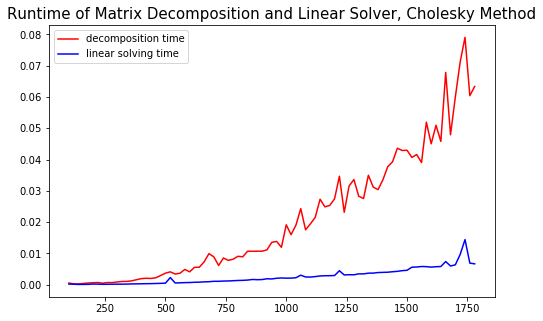

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(n_size,decomp_time, '-', c = 'r', label = 'decomposition time' )
plt.plot(n_size, lin_solve_time, '-', c = 'b', label = 'linear solving time')
plt.title('Runtime of Matrix Decomposition and Linear Solver, Cholesky Method', fontsize = 15)
plt.legend()


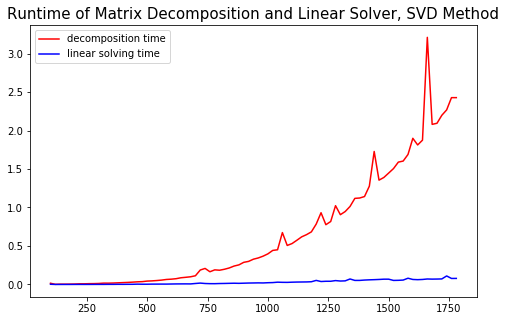

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(n_size,decomp_time_2, '-', c = 'r', label = 'decomposition time' )
plt.plot(n_size, lin_solve_time_2, '-', c = 'b', label = 'linear solving time')
plt.title('Runtime of Matrix Decomposition and Linear Solver, SVD Method', fontsize = 15)
plt.legend()

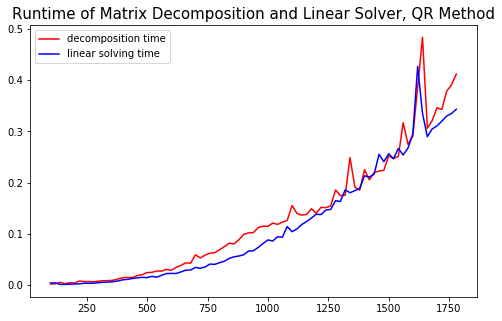

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(n_size_3,decomp_time_3, '-', c = 'r', label = 'decomposition time' )
plt.plot(n_size_3, lin_solve_time_3, '-', c = 'b', label = 'linear solving time')
plt.title('Runtime of Matrix Decomposition and Linear Solver, QR Method', fontsize = 15)
plt.legend()

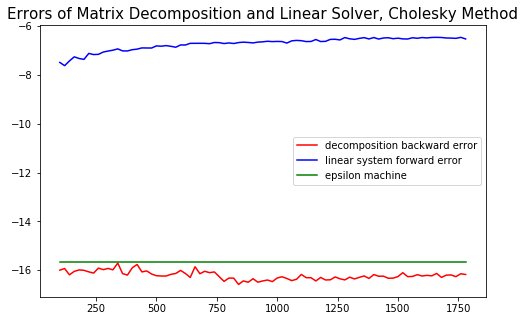

In [31]:
plt.figure(figsize=(8, 5))
decomp_error_log = [np.log10(i) for i in decomp_error]
lin_forerror_log = [np.log10(i) for i in lin_forerror]
eps_machine = [np.log10(np.finfo(float).eps) for i in range(len(decomp_error))]

plt.plot(n_size, decomp_error_log, '-', c = 'r', label = 'decomposition backward error' )
plt.plot(n_size, lin_forerror_log, '-', c = 'b', label = 'linear system forward error')
plt.plot(n_size, eps_machine, '-', c = 'g', label = 'epsilon machine')
plt.title('Errors of Matrix Decomposition and Linear Solver, Cholesky Method', fontsize = 15)
plt.legend()


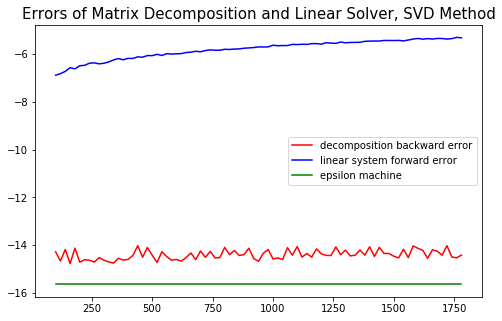

In [32]:
plt.figure(figsize=(8, 5))
decomp_error_log_2 = [np.log10(i) for i in decomp_error_2]
lin_forerror_log_2 = [np.log10(i) for i in lin_forerror_2]
eps_machine = [np.log10(np.finfo(float).eps) for i in range(len(decomp_error_2))]

plt.plot(n_size_2, decomp_error_log_2, '-', c = 'r', label = 'decomposition backward error' )
plt.plot(n_size_2, lin_forerror_log_2, '-', c = 'b', label = 'linear system forward error')
plt.plot(n_size_2, eps_machine, '-', c = 'g', label = 'epsilon machine')
plt.title('Errors of Matrix Decomposition and Linear Solver, SVD Method', fontsize = 15)
plt.legend()

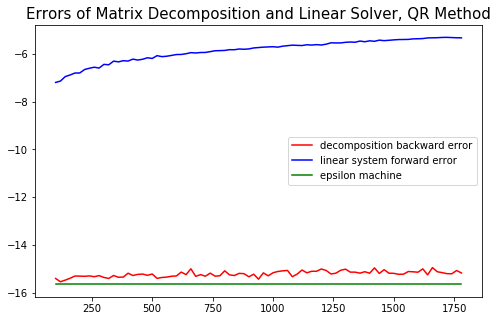

In [33]:
plt.figure(figsize=(8, 5))
decomp_error_log_3 = [np.log10(i) for i in decomp_error_3]
lin_forerror_log_3 = [np.log10(i) for i in lin_forerror_3]
eps_machine = [np.log10(np.finfo(float).eps) for i in range(len(decomp_error_3))]

plt.plot(n_size_3, decomp_error_log_3, '-', c = 'r', label = 'decomposition backward error' )
plt.plot(n_size_3, lin_forerror_log_3, '-', c = 'b', label = 'linear system forward error')
plt.plot(n_size_3, eps_machine, '-', c = 'g', label = 'epsilon machine')
plt.title('Errors of Matrix Decomposition and Linear Solver, QR Method', fontsize = 15)
plt.legend()
